dumping data of board: 4000
root fitting


Warning in <TCanvas::Constructor>: Deleting canvas with same name: cscan
Info in <TCanvas::Print>: png file /workdir/data/pasttrec_quality/fit/PT_0000_noiseFit_channel000.png has been created
Info in <TCanvas::Print>: png file /workdir/data/pasttrec_quality/fit/PT_0000_noiseFit_channel001.png has been created


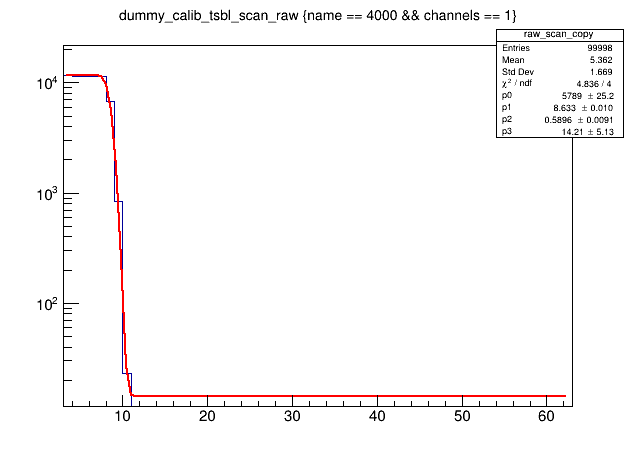

In [6]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:



#----- default settings for the mass test, don't change:
measure_board_list=[ "4000"]
# PASTTREC ASIC parameters:
pt_pktime = 15
pt_gain = 4
pt_threshold_default = 20

data_output_dicrectory="/workdir/data/pasttrec_quality"


# In[2]:


#%matplotlib notebook  
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pasttrec_ctrl as ptc
import json
import sigproc_kit
import tdc_daq as td
import baseline_calib
import ROOT
from ROOT import gROOT
import db
from cw_pasttrec_functions import *

from my_utils import *
set_width_max_of_jupyterpad()

    
def hist_rms(x,y):
  counts = np.sum(y)
  weights = y / counts
  mean = np.dot(x,weights)
  deviations = x - mean
  return np.sqrt(np.dot(deviations**2,weights))
def list_rms(x):
  mean = sum(x)/len(x)
  deviations =  np.asarray(x) -  np.asarray(mean)
  return np.sqrt(sum(deviations**2) /len(x))
def MeanArrays(xs,ys):
    return np.dot(xs,ys)/sum(ys)
def fwhm(x,y):
  dummy, t1, tot = sigproc_kit.discriminate(x,y,np.max(y)/2.,0,0)
  return tot


name = "4000"

# serial number of PASTTREC, needs to be edit for each PASTTREC tested: 
serial = "0000"
root_name = data_output_dicrectory + "/noise_" + name + ".root"
        #save to root file 
db.dump_db_to_root_board(root_name,name)
        #save to root file 
#db.dump_db_to_csv(root_name+".csv",only_board="4000")

# analyse/fit results noise dpendence:
gif_out_list = []

import root_fit as fit
import os.path

# threshold scan scurve fit quality limit to store results
chisquare_limit = 80
n_channels = 2

#noise_plots = ["amplitude","half max","sigma","offset"]
#noise_plots_data = [[]*len(measure_board_list)]*2*len(noise_plots)
#noise_plots_data_x = []*len(measure_board_list)
noise_halfmax = []
noise_halfmax_err = [] 
noise_sigma = []
noise_sigma_err = []

# create fit directory
fit_dir = data_output_dicrectory + "/fit"
if not os.path.isdir(fit_dir):
        os.mkdir(fit_dir)
#clear older fit plots
else:
    os.system("rm -rf {:s}/*png".format(fit_dir))

gif_out_list += [fit_dir]    
if os.path.isfile(root_name):
    print("root fitting")               
    f = ROOT.TFile(root_name)
    #gROOT.SetBatch()
    cscan = ROOT.TCanvas("cscan","The Canvas Title",640,480); cscan.cd();
    dummy_tsbl_tree = f.Get("dummy_tsbl_tree")
    for i in range(0,0+n_channels):

       #ndata = dummy_tsbl_tree.Draw("dummy_calib_tsbl_scan_raw>>raw_scan(33,0,30)","name == " + name  + " && wires == " + str(i)  )
       ndata = dummy_tsbl_tree.Draw("dummy_calib_tsbl_scan_raw>>raw_scan(60,3,63)","name == " + str(name) + " && channels == " + str(i))# + " && layer == 8 && chamber == 8"  )
       #ndata = dummy_tsbl_tree.Draw("dummy_calib_tsbl_scan_raw>>raw_scan(140,-10,130)","") 
        #"name == " + name   )       
        
       if (ndata > 0): 

               raw_scan = f.Get("raw_scan")
               ROOT.gStyle.SetOptFit(1)
               results = fit.fit_scurve(raw_scan, 0, chisquare_limit)
               raw_scan.DrawCopy()
               cscan.SetLogy(1)
               cscan.Draw()
               cscan.Update()
               fit_picture_file = fit_dir+"/PT_"+serial+"_noiseFit_channel{:03d}".format(i) +".png"
               cscan.SaveAs(fit_picture_file)
               #noise_plots_data += [results]
               noise_halfmax += [results[2]]
               noise_halfmax_err += [results[3]] 
               noise_sigma += [results[4]]
               noise_sigma_err += [results[5]]                                       


In [2]:
print(noise_sigma)

[0.8220568197431, 0.5896001826742658]


In [3]:
import pasttrec_ctrl as ptc
ptc.init_active_boards()

import os

os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3AOUTPUT2%20ON'")
os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3ASOUR2%3AFREQ%201000'")
os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3ASOUR2%3AVOLT%3ALEV%3AHIGH%202000mV'")
os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3ASOUR2%3AVOLT%3ALEV%3ALOW%200mV'")
#os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3ASOUR2%3AVOLT%3ALEV%3AOFFS%200mV'")
os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3ASOUR2%3APULS%3ADEL%200'")
os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3ASOUR2%3APULS%3AWIDT%20300n'")
os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3ASOUR2%3APULS%3ATRAN%3ALEAD%2025ns'")
os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3ASOUR2%3APULS%3ATRAN%3ATRA%2050ns'")
#os.system("curl 'http://jspc29:1290/tools/vxi/vxi.pl?192.168.0.42&%3AOUTPUT2%20OFF'")


13312

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (52) Empty reply from server
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (52) Empty reply from server
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
curl: (52) Empty reply from server
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0 